In [279]:
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from tqdm import tqdm
import pickle

from scipy.optimize import minimize as sci_minimize
from scipy.optimize import basinhopping
from scipy.integrate import quad
from scipy import interpolate
from scipy.io import loadmat
from scipy.stats import circmean, circstd
from scipy.signal import hilbert, convolve

!pip install brian2hears
from brian2 import *
from brian2hears import *

In [68]:
def download_cipic(subject='058', verbose = False):
  url = f"https://raw.githubusercontent.com/amini-allight/cipic-hrtf-database/master/standard_hrir_database/subject_{subject}/hrir_final.mat"
  result = subprocess.run(["wget", url], stderr=subprocess.PIPE, stdout=subprocess.PIPE)
  if verbose:
    print(result.stderr.decode("utf-8"))

def load_cipic(filename='./hrir_final.mat'):
  return loadmat(filename)

def wrapToPi(x):
  return (x+np.pi)%(2*np.pi)-np.pi

def ipd2itd(ipd, freq):
  return ipd/(freq*2*np.pi)

In [40]:
download_cipic(verbose=True)

--2024-06-06 21:35:46--  https://raw.githubusercontent.com/amini-allight/cipic-hrtf-database/master/standard_hrir_database/subject_058/hrir_final.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4030520 (3.8M) [application/octet-stream]
Saving to: ‘hrir_final.mat’

     0K .......... .......... .......... .......... ..........  1% 2.34M 2s
    50K .......... .......... .......... .......... ..........  2% 15.4M 1s
   100K .......... .......... .......... .......... ..........  3% 5.84M 1s
   150K .......... .......... .......... .......... ..........  5% 30.2M 1s
   200K .......... .......... .......... .......... ..........  6% 31.6M 1s
   250K .......... .......... .......... .......... ..........  7% 22.2M 0s
   300K .......... .......... .......... ..

In [41]:
cipic_db = load_cipic('./hrir_final.mat')

In [46]:
cipic_db['name']

array(['subject_058'], dtype='<U11')

In [47]:
cipic_db['hrir_l'].shape

(25, 50, 200)

In [51]:
hrir_l = np.squeeze(cipic_db['hrir_l'][:, 9, :])
hrir_r = np.squeeze(cipic_db['hrir_r'][:, 9, :])

In [271]:
Sf = 44100 #sampling frequency
trim = int(.25*Sf)

sound = np.squeeze(2*(np.random.rand(1,4*Sf)-0.5), axis=0)

freqs = np.arange(400, 1250, 100)
#azims = range(0,360,15)
azims = np.concatenate(([-80, -65, -55], np.arange(-45, 45, 5), [55, 65, 80]))

#center_freqs = np.linspace(100, 1000, 50)#erbspace(100*Hz, 1000*Hz, 50) #filtro coclear

ipd_means = np.zeros((len(azims), len(freqs)))
ipd_stds = np.zeros_like(ipd_means)

itd_means = np.zeros_like(ipd_means)
itd_stds = np.zeros_like(ipd_means)

for i, az in tqdm(enumerate(azims)):
    convolved_l = Sound(convolve(sound, hrir_l[i]), samplerate=Sf*Hz)
    convolved_r = Sound(convolve(sound, hrir_r[i]), samplerate=Sf*Hz)

    cochlear_l = Gammatone(convolved_l, freqs).process()  #TODO: ver como fazer estéreo direto (Tile/Join)
    cochlear_r = Gammatone(convolved_r, freqs).process()

    for cl, cr, j in zip(cochlear_l.T, cochlear_r.T, range(len(freqs))):  # iterate over cochelar filter center freqs
        transformed = hilbert(np.stack((cl, cr)), axis=1)

        ipd = wrapToPi(np.diff(np.angle(transformed), axis=0))[0, :]
        ipd = ipd[trim:-trim]

        ipd_mean = circmean(ipd, high=np.pi, low=-np.pi)
        ipd_std = circstd(ipd, high=np.pi, low=-np.pi)

        ipd_means[i,j] = ipd_mean
        ipd_stds[i,j] = ipd_std

        itd_means[i,j] = ipd2itd(ipd_mean, freqs[j])
        itd_stds[i,j] = ipd2itd(ipd_std, freqs[j])



24it [00:42,  1.79s/it]


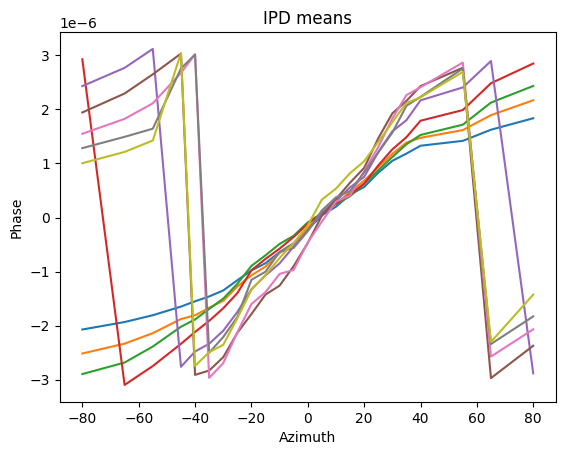

In [302]:
for i in range(len(freqs)):
  plt.plot(azims, ipd_means[:, i]*1e-6, '-')
plt.title('IPD means')
plt.ylabel('Phase')
plt.xlabel('Azimuth')
plt.show()

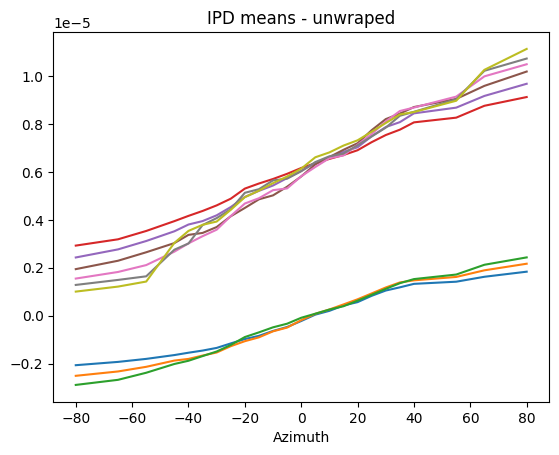

In [306]:
for i in range(len(freqs)):
  plt.plot(azims, np.unwrap(ipd_means[:, i], period=2*np.pi)*1e-6, '-')
plt.title('IPD means - unwraped')
plt.xlabel('Azimuth')
plt.show()

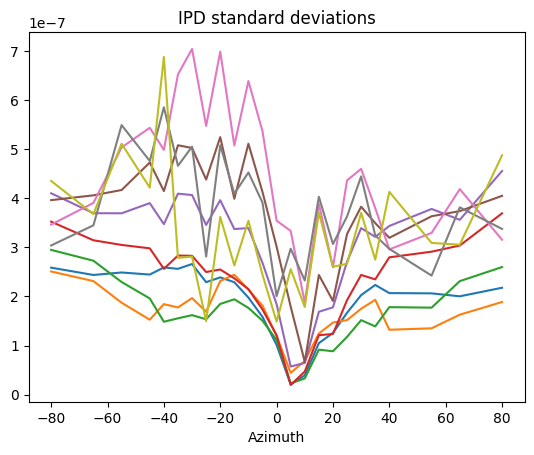

In [301]:
for i in range(len(freqs)):
  plt.plot(azims, ipd_stds[:, i]*1e-6, '-')
plt.title('IPD standard deviations')
plt.xlabel('Azimuth')
plt.show()

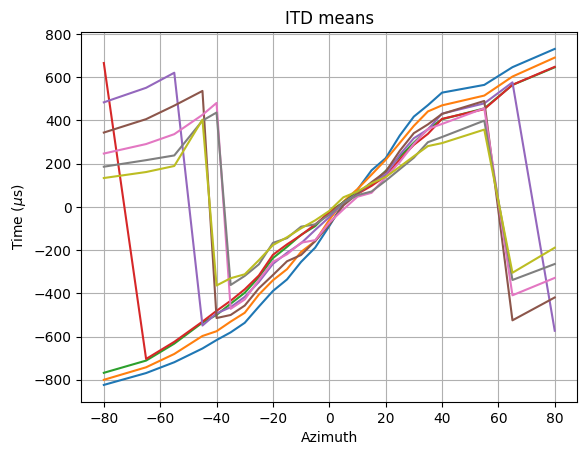

In [304]:
for i in range(len(freqs)):
  plt.plot(azims, itd_means[:, i]*1e6, '-', label=freqs[i])
plt.title('ITD means')
plt.ylabel(r'Time ($\mu$s)')
plt.xlabel('Azimuth')
#plt.legend()
plt.grid()
plt.show()

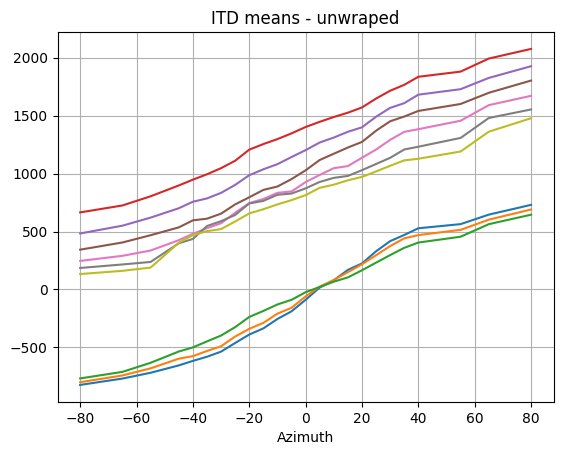

In [307]:
for i in range(len(freqs)):
  plt.plot(azims, ipd2itd(np.unwrap(ipd_means[:, i]), freqs[i])*1e6, '-', label=freqs[i])
plt.title('ITD means - unwraped')
plt.xlabel('Azimuth')
plt.grid()
plt.show()

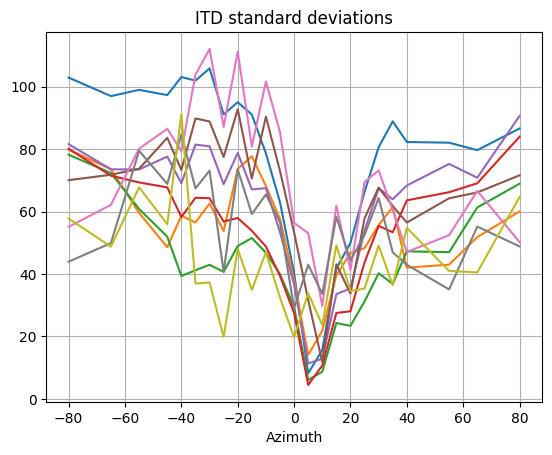

In [278]:
for i in range(len(freqs)):
  plt.plot(azims, itd_stds[:, i]*1e6, '-')
plt.title('ITD standard deviations')
plt.xlabel('Azimuth')
plt.grid()
plt.show()

# Acoustic Fisher Information

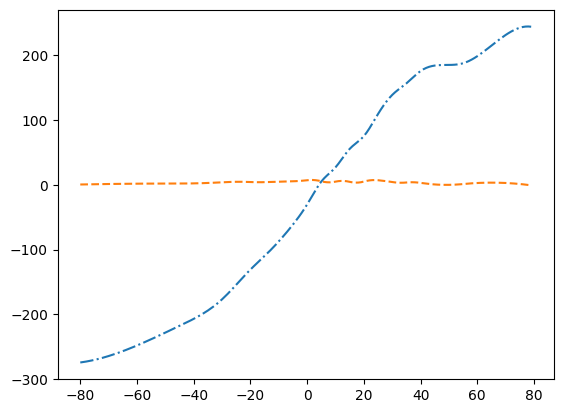

In [292]:
azimuths = np.arange(-80, 80, 1)

spline = interpolate.splrep(azims, ipd2itd(np.unwrap(ipd_means[:, 0]), freqs[i])*1e6, s=len(azims))
dspline = interpolate.splev(azimuths, spline, der=1)

plt.plot(azimuths, interpolate.BSpline(*spline)(azimuths), '-.')
plt.plot(azimuths, dspline, '--')

In [295]:
azimuths = np.arange(-80, 80, 1)

fisher_info = np.zeros((len(azimuths), len(freqs)))

for i in range(len(freqs)):
  #fitar media
  mean_fit = interpolate.splrep(azims, ipd2itd(np.unwrap(ipd_means[:, i]), freqs[i])*1e6, s=len(azims))
  #derivada da media
  dmean = interpolate.splev(azimuths, mean_fit, der=1)

  #fitar desvio padrao
  std_fit = interpolate.splrep(azims, itd_stds[:, i]*1e6, s=len(azims))
  std = interpolate.BSpline(*std_fit)(azimuths)
  #derivada desvio padrao
  dstd = interpolate.splev(azimuths, std_fit, der=1)

  #fisher information = (derivada da media/desvio padrao)^2 + 2*(derivada do desvio/desvio padrao)^2
  fisher_info[:, i] = np.power(dmean/std, 2) + (2*np.power(dstd/std, 2))

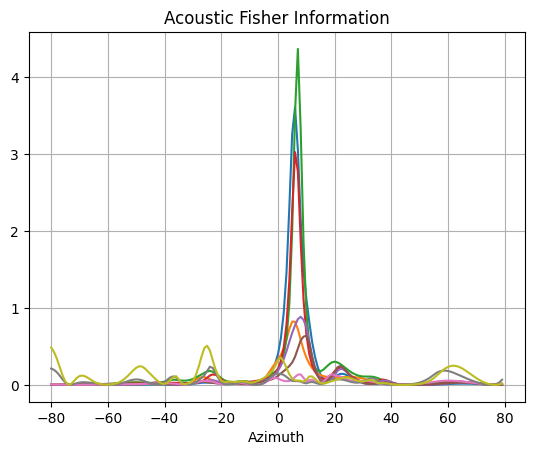

In [309]:
for i in range(len(freqs)):
  plt.plot(azimuths, fisher_info[:, i], '-', label=freqs[i])
plt.title('Acoustic Fisher Information')
plt.xlabel('Azimuth')
plt.grid()
plt.show()

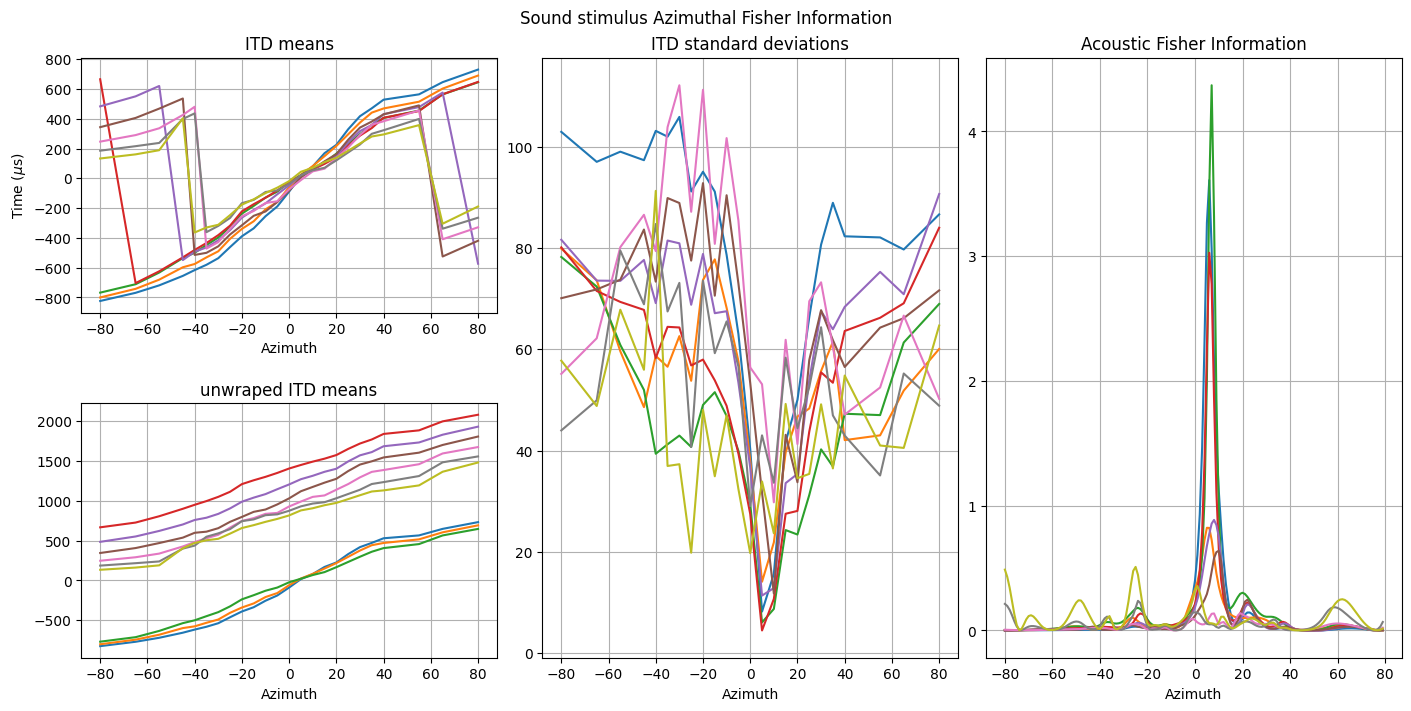

In [322]:
fig, axd = plt.subplot_mosaic([['upper left', 'center', 'right'],
                               ['lower left', 'center', 'right']],
                              figsize=(14, 7), layout="constrained")
for k, ax in axd.items():
  if k == 'upper left':
    for i in range(len(freqs)):
      ax.plot(azims, itd_means[:, i]*1e6, '-', label=freqs[i])
    ax.set_title('ITD means')
    ax.set_ylabel(r'Time ($\mu$s)')
    ax.set_xlabel('Azimuth')
    #ax.legend()
    ax.grid()

  elif k == 'lower left':
    for i in range(len(freqs)):
      ax.plot(azims, ipd2itd(np.unwrap(ipd_means[:, i]), freqs[i])*1e6, '-', label=freqs[i])
    ax.set_title('unwraped ITD means')
    #ax.ylabel(r'Time ($\mu$s)')
    ax.set_xlabel('Azimuth')
    #ax.legend()
    ax.grid()

  elif k == 'center':
    for i in range(len(freqs)):
      ax.plot(azims, itd_stds[:, i]*1e6, '-')
    ax.set_title('ITD standard deviations')
    ax.set_xlabel('Azimuth')
    ax.grid()

  elif k == 'right':
    for i in range(len(freqs)):
      ax.plot(azimuths, fisher_info[:, i], '-', label=freqs[i])
    ax.set_title('Acoustic Fisher Information')
    ax.set_xlabel('Azimuth')
    ax.grid()

fig.suptitle('Sound stimulus Azimuthal Fisher Information');

In [323]:
fig.savefig('FI_Acoustic-demo', dpi=300)